In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy import stats

# EDA: Car Insurance Cold Calls

## Explore the data

The data set we will use for this exercise comes from the featured Kaggle datasets, containing data about cold calls to both existing and potential car insurance customers. The data provides some demographic data about each person called (customer), such as age, job, marital status and education, along with call details and some features indicating insurance status.

The goal here is to perform exploratory data analysis (EDA), using both visual EDA and some statistics and probability.

For statistics we will use the Chi-square test of independence, which is meant to be used with categorical data. In this case we will be concerned with the effects of some demographic features on the outcome of the calls.

## Exponential distributions
Exponential distributions have the probability density funtion

$$f(x; \lambda) = \begin{cases}
    \lambda e^{-\lambda x} &\text{ } x \geq 0\\
    0 &\text{ } x < 0
    \end{cases}$$

and cumulative density function

$$F(x; \lambda) = 1 - e^{-\lambda x}.$$

The expectation value (mean) is $\lambda^{-1}$ and percentiles can be computed using

$$F^{-1}(p; \lambda) = \frac{-ln(1-p)}{\lambda}$$

Where p is the desired percentile. Since we can easily compute the mean of our data, we can use that to get lamba and thus compute percentiles.

In our case, we can easily compute the mean of our data using pandas:

## Chi-square tests of independence

Chi-square tests are used to compare two categorical variables from a single population; they are used to determine if there is a significant associtation between them. The test has three requirements:

* The two variables being tested are categorical
* They data was acquired using simple random sampling
* The expected frequency count for each cell of a contingency table for the data is at least 5

For this set we will assume the second requirement has been met.

## Problems

1. Compute descriptive statistics for every feature in the data.
    - Create a columm for call duration. Test whether there is a signifiant relationship between call duration and having or not having insurance.
2. Plot a histogram of call durations using 25 bins. The call durations can be modeled using an exponential distribution. What is the expected value for call duration?
3. Estimate the exponential distribution and compute the mean, median, and the 95th percentile. Compare these values to those computed from the data.
    - What are these values for the two groups: has car insurance, and doesn't have car insurance?
4. Write a function to select only features that could be Bernoulli random variables and select one of them to
    - compute the probability that a random sample (n = 10) would contain exactly 3 successes
    - compute the probability that such a sample would contain at most 3 successes
5. Write a function to create a column that categorizes each age according to the following age ranges:
    - 18-24
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65+
6. Create a stacked bar chart showing the frequency of each age group. What are the most and least common groups? Now plot and describe the distribution of ages.
7. Create contingency tables for the following pairs:
    - Marital and Outcome
    - Education and Outcome
    - Job and Outcome
    - age_group and Outcome
8. Transform these contingency tables to show proportions of Outcome by each independent variable (Education, etc.). Plot these tables as heatmaps.
9. Run Chi-square tests for independence (alpha = 0.05) on all the contingency tables and interpret the results.
10. Which of these contingency tables are not appropriate for a Chi-square test? Why not?
    - Redo the tests using only "failure" and "success" outcomes, and interpret the results. Is the Job table still not appropriate for chi-square?

In [28]:
insurance = pd.read_csv('data/car_insurance.csv')
# very useful from the solution: add parse_dates=list_of_dates to have some columns already in datetime format!

In [4]:
insurance.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


## 1. Compute descriptive statistics for every feature in the data

In [5]:
insurance.shape

(4000, 19)

In [6]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
Id                  4000 non-null int64
Age                 4000 non-null int64
Job                 3981 non-null object
Marital             4000 non-null object
Education           3831 non-null object
Default             4000 non-null int64
Balance             4000 non-null int64
HHInsurance         4000 non-null int64
CarLoan             4000 non-null int64
Communication       3098 non-null object
LastContactDay      4000 non-null int64
LastContactMonth    4000 non-null object
NoOfContacts        4000 non-null int64
DaysPassed          4000 non-null int64
PrevAttempts        4000 non-null int64
Outcome             958 non-null object
CallStart           4000 non-null object
CallEnd             4000 non-null object
CarInsurance        4000 non-null int64
dtypes: int64(11), object(8)
memory usage: 593.8+ KB


In [7]:
insurance.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,4000,NaN,NaN,NaN,2000.5,1154.84,1,1000.75,2000.5,3000.25,4000
Age,4000,NaN,NaN,NaN,41.2148,11.5502,18,32,39,49,95
Job,3981,11,management,893,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,4000,3,married,2304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,3831,3,secondary,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Default,4000,NaN,NaN,NaN,0.0145,0.119555,0,0,0,0,1
Balance,4000,NaN,NaN,NaN,1532.94,3511.45,-3058,111,551.5,1619,98417
HHInsurance,4000,NaN,NaN,NaN,0.49275,0.50001,0,0,0,1,1
CarLoan,4000,NaN,NaN,NaN,0.133,0.339617,0,0,0,0,1
Communication,3098,2,cellular,2831,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create call_duration column

In [8]:
# print(min(pd.to_datetime(insurance.CallStart)), max(pd.to_datetime(insurance.CallStart)))
# print(min(pd.to_datetime(insurance.CallEnd)), max(pd.to_datetime(insurance.CallEnd)))

insurance['call_duration'] = (pd.to_datetime(insurance.CallEnd) - pd.to_datetime(insurance.CallStart)).astype('timedelta64[s]')

In [9]:
insurance.call_duration.head()

0     70.0
1    185.0
2    340.0
3    819.0
4    192.0
Name: call_duration, dtype: float64

### With and Without Car Insurance

In [10]:
insurance[['CarInsurance', 'call_duration']].corr()

,CarInsurance,call_duration
CarInsurance,1.000000,0.480346
call_duration,0.480346,1.000000


The variables doesn't seem to be highly correlated.

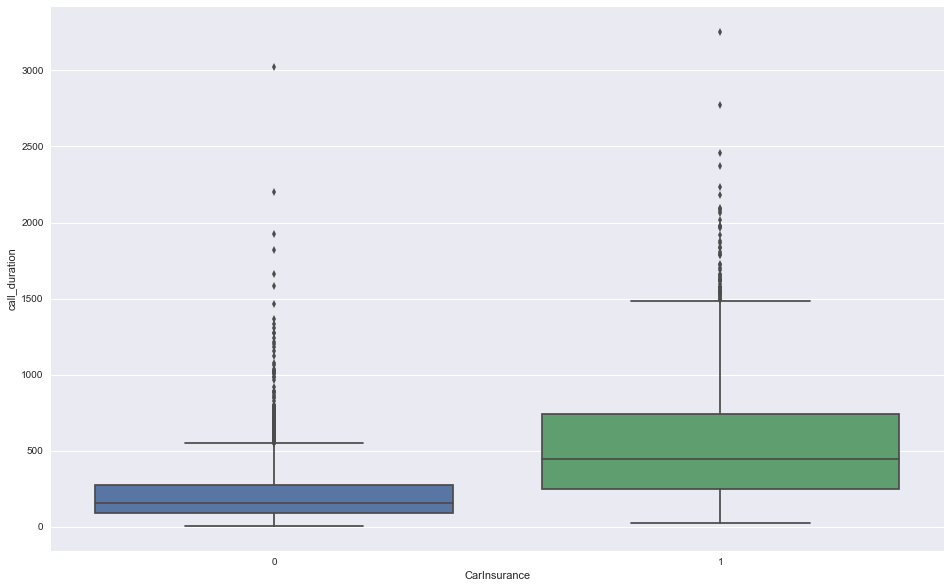

In [12]:
fig = plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='CarInsurance', y='call_duration', data=insurance);

In the solutions a t-test is performed, but it isn't very useful so I'm not reproducing it.

## 2. a) Plot a histogram of call durations using 25 bins

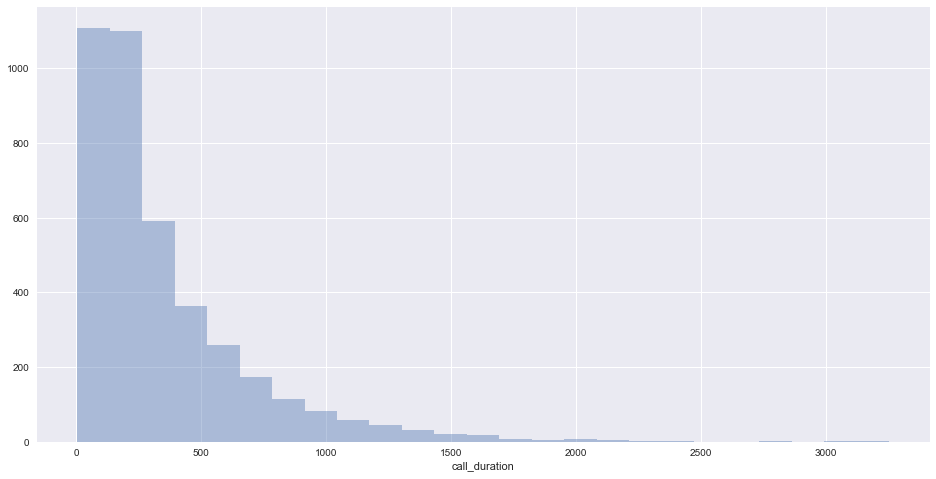

In [14]:
fig = plt.figure(figsize=(16, 8))
ax = sns.distplot(insurance.call_duration, bins=25, kde=False);

## 2. b) Expected Call Duration

In [15]:
insurance.call_duration.mean()

350.844

## 3. Estimate the exponential distribution and compute the mean, median, and the 95th percentile

In [16]:
l = insurance.call_duration.mean()**-1

mean_est = l**-1
median_est = -np.log(1-0.5)/l
perc95_est = -np.log(1-0.95)/l

print('Estimated mean, median and 95th percentile: {:.5f}, {:.5f}, {:.5f}'.format(
    mean_est,
      median_est,
      perc95_est))

Estimated mean, median and 95th percentile: 350.84400, 243.18653, 1051.03469


In [17]:
print('Mean, median and 95th percentile: {:.5f}, {:.5f}, {:.5f}'.format(
    insurance.call_duration.mean(),
      insurance.call_duration.median(),
      insurance.call_duration.quantile(0.95)))

Mean, median and 95th percentile: 350.84400, 232.00000, 1058.20000


### What are these values for the two groups: has car insurance, and doesn't have car insurance?

In [18]:
print('Has car insurance mean, median and 95th percentile: {:.5f}, {:.5f}, {:.5f}'.format(
    insurance[insurance.CarInsurance == 1].call_duration.mean(),
      insurance[insurance.CarInsurance == 1].call_duration.median(),
      insurance[insurance.CarInsurance == 1].call_duration.quantile(0.95)))

print('Doesn\'t have car insurance mean, median and 95th percentile: {:.5f}, {:.5f}, {:.5f}'.format(
    insurance[insurance.CarInsurance == 0].call_duration.mean(),
      insurance[insurance.CarInsurance == 0].call_duration.median(),
      insurance[insurance.CarInsurance == 0].call_duration.quantile(0.95)))

Has car insurance mean, median and 95th percentile: 551.73815, 447.00000, 1343.55000
Doesn't have car insurance mean, median and 95th percentile: 216.35559, 157.00000, 582.50000


## 4. Write a function to select only features that could be binomial random variables and select one of them to
* compute the probability that a random sample (n = 10) would contain exactly 3 successes
* compute the probability that such a sample would contain at most 3 successes

### Write a function to select only features that could be binomial random variables

In [19]:
for col in insurance.columns:
    if set(insurance[col].unique()) == set([0, 1]):
        print(col)

Default
HHInsurance
CarLoan
CarInsurance


### Compute P(X = 3)

In [20]:
from scipy.special import binom as binom
p = insurance.CarInsurance.sum()/insurance.CarInsurance.count()
print(binom(10, 3) * p**3 * (1-p)**7)
print(stats.binom.pmf(3, n=10, p=p))

0.214092828857
0.214092828857


### Compute P(X &leq; 3)

In [21]:
print(stats.binom.cdf(3, n=10, p=p))

0.379775522486


## 5. Write a function to create a column that categorizes each age according to the following age ranges:
    - 18-24
    - 25-34
    - 35-44
    - 45-54
    - 55-64
    - 65+

In [29]:
def age_cat(df):
    if df.Age >= 65:
        return '65+'
    elif df.Age >= 55:
        return '55-64'
    elif df.Age >= 45:
        return '45-54'
    elif df.Age >= 35:
        return '35-44'
    elif df.Age >= 25:
        return '25-34'
    elif df.Age >= 18:
        return '18-24'
    else:
        return('Something strange')

In [30]:
insurance['age_categories'] = insurance.apply(age_cat, axis=1)

## 6. Create a stacked bar chart showing the frequency of each age group. What are the most and least common groups?

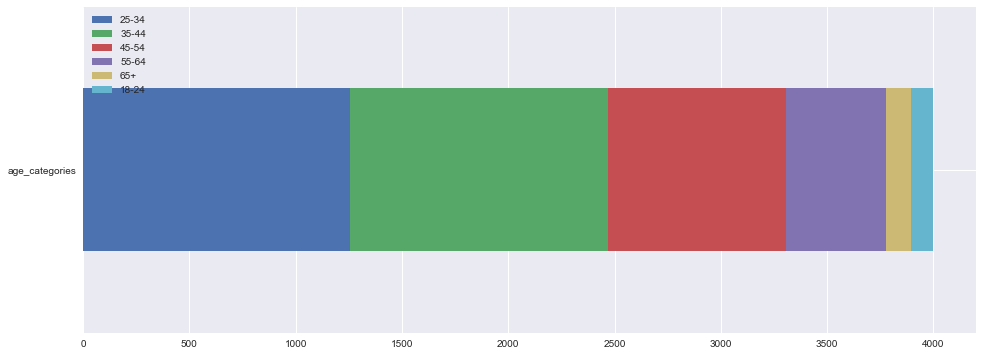

In [59]:
# fig = plt.figure(figsize=(16, 6))
# ax = plt.axes()
# ax = sns.barplot(x='index', y='age_categories', stacked=True, data=insurance.age_categories.value_counts().reset_index())
# ax.set_xlabel('Age Categories')
# ax.set_ylabel('Count');

ax = pd.DataFrame(insurance.age_categories.value_counts()).T.plot.barh(figsize=(16, 6), stacked=True)

### Now plot and describe the distribution of ages

C:\Users\alessandro.diantonio\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


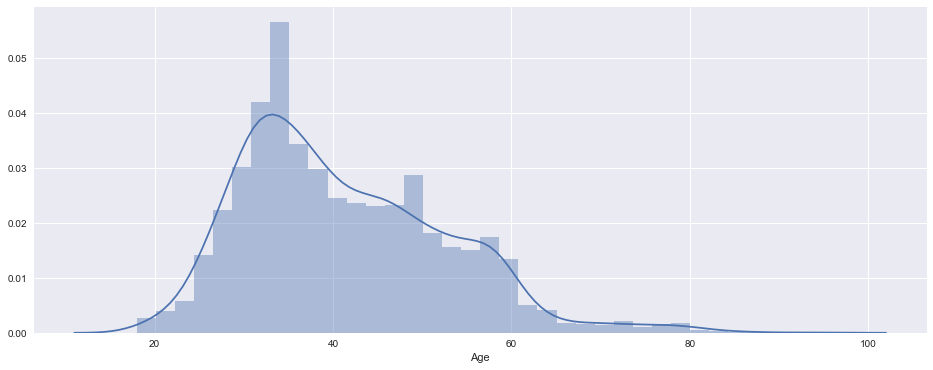

In [37]:
fig = plt.figure(figsize=(16, 6))
ax = plt.axes()
ax = sns.distplot(insurance.Age);

The distribution seems normal but it is a little skewed to the right and it has two other peaks, it could be closer to a bimodal distribution.

In [61]:
print(insurance.Age.describe())
print(insurance.Age.skew())
print(insurance.Age.kurtosis())

count    4000.000000
mean       41.214750
std        11.550194
min        18.000000
25%        32.000000
50%        39.000000
75%        49.000000
max        95.000000
Name: Age, dtype: float64
0.763293030196
0.492527093977


## 7. Create contingency tables for the following pairs:
    - Education and Outcome
    - CarInsurance and Outcome
    - Job and Outcome
    - age_group and Outcome

In [55]:
edu_contingency = pd.pivot_table(insurance, values='Id', index='Education', columns='Outcome', aggfunc='count', margins=True)
ins_contingency = pd.pivot_table(insurance, values='Id', index='CarInsurance', columns='Outcome', aggfunc='count', margins=True)
job_contingency = pd.pivot_table(insurance, values='Id', index='Job', columns='Outcome', aggfunc='count', margins=True)
age_contingency = pd.pivot_table(insurance, values='Id', index='age_categories', columns='Outcome', aggfunc='count', margins=True)

In [59]:
print('Education vs. Outcome:\n\n{}\n\n'.format(edu_contingency))
print('Car insurance vs. Outcome:\n\n{}\n\n'.format(ins_contingency))
print('Job vs. Outcome:\n\n{}\n\n'.format(job_contingency))
print('Age category vs. Outcome:\n\n{}\n\n'.format(age_contingency))

Education vs. Outcome:

Outcome    failure  other  success    All
Education                                
primary       50.0   28.0     24.0  102.0
secondary    223.0   95.0    147.0  465.0
tertiary     148.0   63.0    137.0  348.0
All          421.0  186.0    308.0  915.0


Car insurance vs. Outcome:

Outcome       failure  other  success    All
CarInsurance                                
0               261.0  103.0     35.0  399.0
1               176.0   92.0    291.0  559.0
All             437.0  195.0    326.0  958.0


Job vs. Outcome:

Outcome        failure  other  success    All
Job                                          
admin.            56.0   31.0     33.0  120.0
blue-collar       76.0   27.0     33.0  136.0
entrepreneur      13.0    1.0      2.0   16.0
housemaid          9.0    4.0      2.0   15.0
management       108.0   43.0     94.0  245.0
retired           16.0   11.0     43.0   70.0
self-employed      9.0    8.0     11.0   28.0
services          38.0   11.0     2

## 8. Transform these contingency tables to show proportions of Outcome by each independent variable (Education, etc.). Plot these tables as heatmaps.

In [67]:
def contingency_heatmap(df):
    data = df.drop('All').drop('All', axis=1) / df.loc['All', 'All']
    fig = plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data)

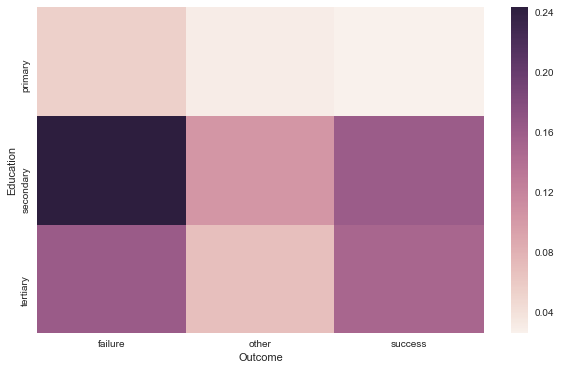

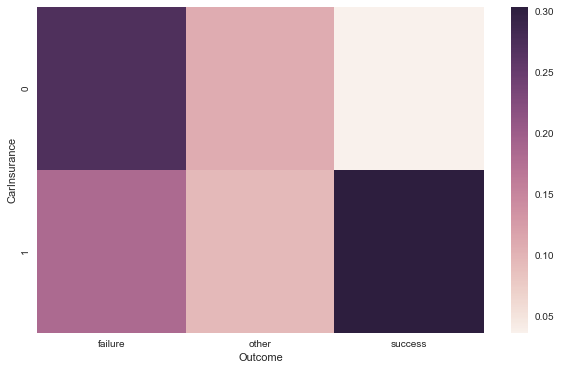

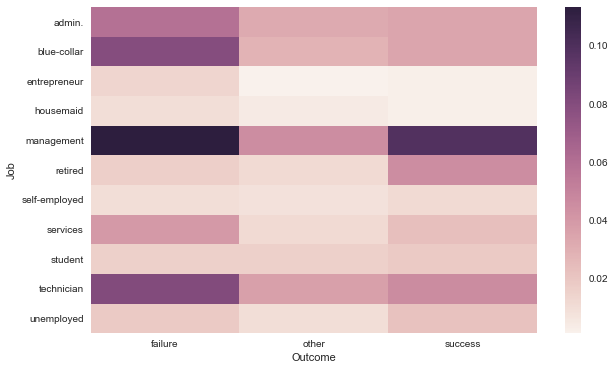

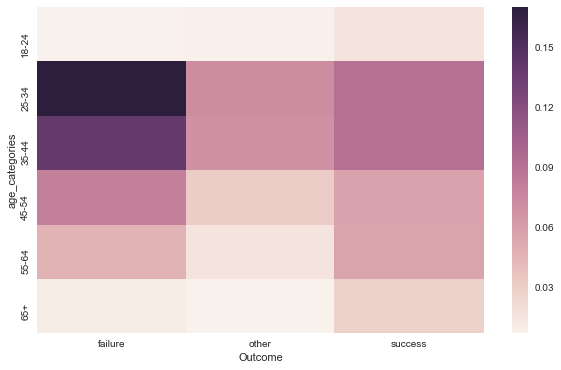

In [68]:
contingency_heatmap(edu_contingency)
contingency_heatmap(ins_contingency)
contingency_heatmap(job_contingency)
contingency_heatmap(age_contingency)

## 9. Run Chi-square tests for independence (alpha = 0.05) on all the contingency tables and interpret the results.

In [70]:
stats.chi2_contingency(edu_contingency.drop('All').drop('All', axis=1))

(11.952816277914444,
 0.017705606327210261,
 4,
 array([[  46.93114754,   20.73442623,   34.33442623],
        [ 213.95081967,   94.52459016,  156.52459016],
        [ 160.11803279,   70.74098361,  117.14098361]]))

In [72]:
stats.chi2_contingency(ins_contingency.drop('All').drop('All', axis=1))

(196.95589456839059,
 1.7043975659567056e-43,
 2,
 array([[ 182.00730689,   81.21607516,  135.77661795],
        [ 254.99269311,  113.78392484,  190.22338205]]))

In [73]:
stats.chi2_contingency(job_contingency.drop('All').drop('All', axis=1))

(61.785049632441783,
 3.7565863838377321e-06,
 20,
 array([[  54.77439664,   24.55403987,   40.67156348],
        [  62.07764953,   27.82791186,   46.09443861],
        [   7.30325289,    3.27387198,    5.42287513],
        [   6.84679958,    3.06925498,    5.08394544],
        [ 111.83105981,   50.13116474,   83.03777545],
        [  31.95173137,   14.32318993,   23.7250787 ],
        [  12.78069255,    5.72927597,    9.49003148],
        [  32.40818468,   14.52780693,   24.06400839],
        [  21.90975866,    9.82161595,   16.26862539],
        [  71.20671563,   31.92025184,   52.87303253],
        [  21.90975866,    9.82161595,   16.26862539]]))

In [74]:
stats.chi2_contingency(age_contingency.drop('All').drop('All', axis=1))

(38.792661155543612,
 2.7600837200876502e-05,
 10,
 array([[  13.68475992,    6.10647182,   10.20876827],
        [ 145.51461378,   64.93215031,  108.55323591],
        [ 131.3736952 ,   58.62212944,   98.00417537],
        [  73.89770355,   32.97494781,   55.12734864],
        [  52.00208768,   23.2045929 ,   38.79331942],
        [  20.52713987,    9.15970772,   15.3131524 ]]))

## 10. Which of these contingency tables are not appropriate for a Chi-square test? Why not?

Answer: the job table because it has counts under 5 in some cells.

### Redo the tests using only "failure" and "success" outcomes, and interpret the results. Is the Job table still not appropriate for chi-square?

In [77]:
stats.chi2_contingency(edu_contingency.drop('All').drop(['All', 'other'], axis=1))

(7.8431814254510837,
 0.019809558351792121,
 2,
 array([[  42.73525377,   31.26474623],
        [ 213.67626886,  156.32373114],
        [ 164.58847737,  120.41152263]]))

In [78]:
stats.chi2_contingency(ins_contingency.drop('All').drop(['All', 'other'], axis=1))

(186.66149555596792,
 1.7025021333063239e-42,
 1,
 array([[ 169.53079948,  126.46920052],
        [ 267.46920052,  199.53079948]]))

In [79]:
stats.chi2_contingency(job_contingency.drop('All').drop(['All', 'other'], axis=1))

(47.206537724922249,
 8.6599554431890958e-07,
 10,
 array([[  51.07519789,   37.92480211],
        [  62.55277045,   46.44722955],
        [   8.60817942,    6.39182058],
        [   6.31266491,    4.68733509],
        [ 115.92348285,   86.07651715],
        [  33.85883905,   25.14116095],
        [  11.47757256,    8.52242744],
        [  34.43271768,   25.56728232],
        [  18.93799472,   14.06200528],
        [  69.43931398,   51.56068602],
        [  22.38126649,   16.61873351]]))

In [80]:
stats.chi2_contingency(age_contingency.drop('All').drop(['All', 'other'], axis=1))

(31.280226816255265,
 8.2463227172663913e-06,
 5,
 array([[  12.60026212,    9.39973788],
        [ 143.18479685,  106.81520315],
        [ 127.14809961,   94.85190039],
        [  75.60157274,   56.39842726],
        [  56.70117955,   42.29882045],
        [  21.76408912,   16.23591088]]))

The job table still isn't good:

In [81]:
job_contingency.drop('All').drop(['All', 'other'], axis=1)

Outcome,failure,success
Job,,
admin.,56.0,33.0
blue-collar,76.0,33.0
entrepreneur,13.0,2.0
housemaid,9.0,2.0
management,108.0,94.0
retired,16.0,43.0
self-employed,9.0,11.0
services,38.0,22.0
student,15.0,18.0


Thus, from the tests we can say that the Outcome variable is dependent from Education, CarInsurance and age_categories.

# EDA: Flight Cancellations & Delays

## Explore the data

This data set comes from the featured Kaggle datasets, containing three tables that relate to commercial airline flights. The flight delay and cancellation data was collected and published by the DOT's Bureau of Transportation Statistics.

**There are three tables:**

* airlines : contains airline IATA codes with corresponding airline names
* airports : contains
    IATA_CODE:
    Location Identifier
    String

    AIRPORT:
    Airport's Name
    String

    CITY:
    City Name of the Airport
    String

    STATE:
    State Name of the Airport
    String

    COUNTRY:
    Country Name of the Airport
    String

    LATITUDE:
    Latitude of the Airport
    Numeric

    LONGITUDE:
    Longitude of the Airport
    Numeric
* flights : contains many features with descriptions that can be found [here](https://www.kaggle.com/usdot/flight-delays), by selecting flights.csv in the data and clicking on Edit descriptions above the data preview.

We cleaned this data in the cleaning notebook, and recall the mention that we started with a sample of the full set available on Kaggle, in order to reduce processing times.

## Possion distributions / Poisson process
The Poisson distribution represents the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known average rate and independently of the time since the last event. This comment about independence is actually referring to the memoryless property of the exponential distribution (a distribtuion introduced earlier). Put another way, the Poisson distribution represents a process of a series of events that each follow the same exponential distribution.

The Poisson probability formula:

$$P(x; \mu) = e^{-\mu}\frac{\mu^{x}}{x!}$$

where $x$ is the number of successes and $\mu$ is the mean of the distribution.

## Logarithmic transformations

Log transformations can be useful for a number of reasons; two reasons include scaling data for easier interpretation or transforming data to fit a distribution that can be modeled (e.g. making exponential data linear).

Example (notice how x-values beyond 10 are off the charts, but ln(x) is at visible scales out to 1000 and beyond):

![](images/loglin.png)

## Problems

1. Use pandas `apply()` method to create a table that contains the following stats for each airline:
    * flight volume (frequency in the data for each airline)
    * flight proportion (proportion of activity for all airlines)
    * diverted rate
    * cancelled rate
2. Compute the volume of activity by airport and airline/airport pairs and do the following:
    - Visualize volume by airline, airport, and airline/airport pairs
        + use airline names instead of IATA codes
    - Which airline has the highest volume overall? Which airport is the busiest for that airline?
3. Determine expected times between cancellations for an airline of your choosing.
    - Create a table that shows expected time between cancellations, number of cancellations, and number of records per airport.
    - Compute and create a table that shows the expected time between cancellations for this airline by month for the top 10 airports. Create a visual for this.
4. Model the time between cancellations as a Poisson distribution
    - For the Delta Air data for BOS airport in month 5 (May), compute the probability of the expected time between cancellation exceeding 5.
5. Is there a significant difference between the three most active airlines for overall cancellation rates?
6. Show the relationship between travel routes (origin -> destination) and diversion rates for Delta Air and the top 10 airports from earlier
7. Create and fill a column for mean ground speed for every flight in miles/hour
    - Do any of these seem unusual?
    - (distance column is in miles)
8. Create a visual for the mean times of delay reasons for each airline. Create one for delay proportions for each airline.
9. Plot the delay reasons by airline using a parallel coordinates plot
    - this can take a while so use a random sample of 10% of the data

## 1. Use pandas `apply()` method to create a table that contains the following stats for each airline:
* flight volume (frequency in the data for each airline)
* flight proportion (proportion of activity for all airlines)
* diverted rate
* cancelled rate

In [3]:
flights = pd.read_csv('data/flights_cleaned_sm.csv')

In [63]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611571 entries, 0 to 611570
Data columns (total 31 columns):
year                   611571 non-null int64
month                  611571 non-null int64
day                    611571 non-null int64
day_of_week            611571 non-null int64
airline                611571 non-null object
flight_number          611571 non-null int64
tail_number            597204 non-null object
origin_airport         611571 non-null object
destination_airport    611571 non-null object
scheduled_departure    611571 non-null object
departure_time         527757 non-null object
departure_delay        527757 non-null float64
taxi_out               524959 non-null float64
wheels_off             524959 non-null object
scheduled_time         611566 non-null float64
elapsed_time           522965 non-null float64
air_time               524141 non-null float64
distance               611571 non-null int64
wheels_on              524141 non-null object
taxi_in         

In [4]:
airlines = pd.read_csv('data/airlines_cleaned.csv')

In [65]:
flights_volume = flights.groupby('airline')[['cancelled', 'diverted']].mean().merge(
    pd.DataFrame(flights.airline.value_counts()),
    left_index=True,
    right_index=True)
flights_volume.rename(columns={'airline':'flight_volume', 'diverted':'diverted_rate', 'cancelled':'cancelled_rate'}, inplace=True)
flights_volume['flight_proportion'] = flights_volume.flight_volume.apply(lambda x: x/len(flights))

flights_volume

# from solution:
# airline_stats = flights.groupby('airline').apply(
# lambda x: Series({
#     'flight_vol': x['airline'].count(),
#     'flight_prop': x['airline'].count() / len(flights),
#     'diverted_rate': x['diverted'].mean(),
#     'cancelled_rate': x['cancelled'].mean()}))

,cancelled_rate,diverted_rate,flight_volume,flight_proportion
WN,0.120707,0.002104,130241,0.212961
DL,0.045687,0.002052,83328,0.136252
AA,0.137234,0.002302,74282,0.121461
EV,0.223993,0.002353,65868,0.107703
OO,0.155614,0.001777,62456,0.102124
UA,0.122797,0.001715,52485,0.085820
MQ,0.365076,0.001336,40408,0.066072
B6,0.147032,0.002482,28198,0.046107
US,0.173152,0.000809,23488,0.038406
AS,0.039354,0.001609,16161,0.026425


## 2. Compute the volume of activity by airport and airline/airport pairs and do the following:
- Visualize volume by airline, airport, and airline/airport pairs
    + use airline names instead of IATA codes
- Which airline has the highest volume overall? Which airport is the busiest for that airline?

In [7]:
volume_airline_airport = flights.groupby(['airline', 'origin_airport']).year.count()\
    .reset_index()\
    .merge(airlines, left_on='airline', right_on='iata_code', how='left')\
    .drop(['iata_code', 'airline_x'], axis=1)\
    .rename(columns={'origin_airport':'airport', 'airline_y':'airline', 'year':'volume'})

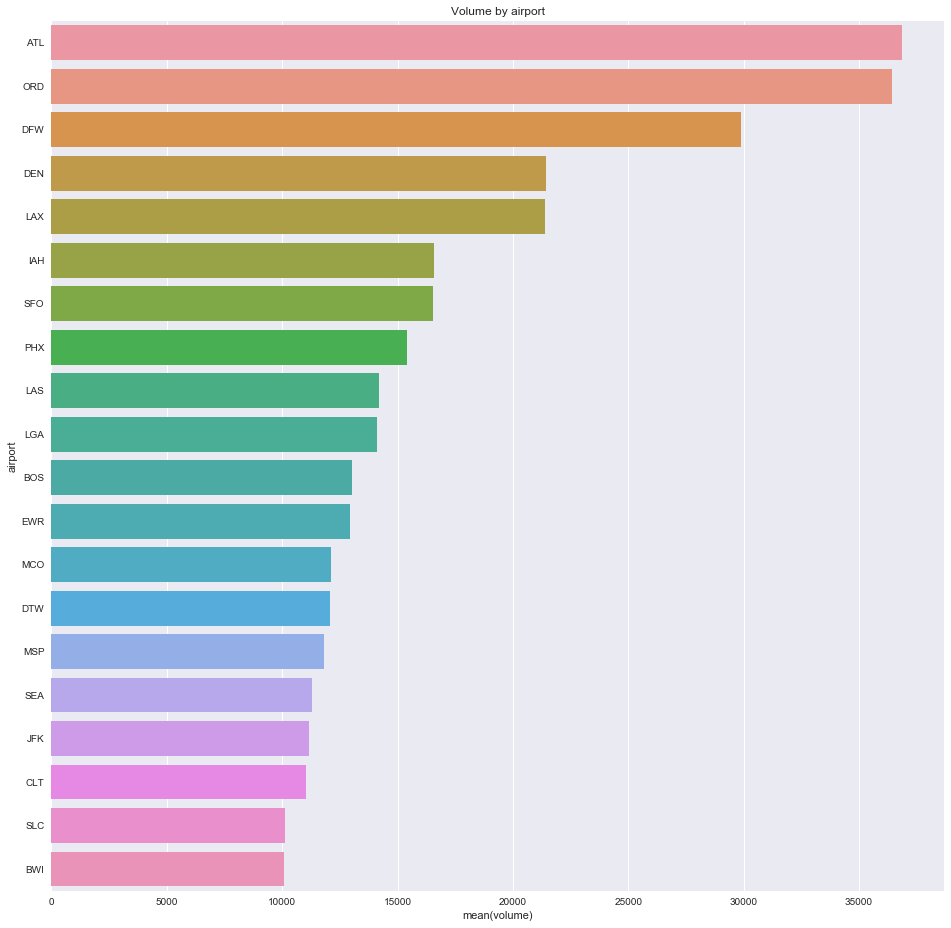

In [8]:
fig = plt.figure(figsize=(16, 16))
ax = sns.barplot(y='airport', x='volume', data=volume_airline_airport.groupby('airport').sum().reset_index().sort_values(by='volume', ascending=False).head(20))
ax.set_title('Volume by airport');

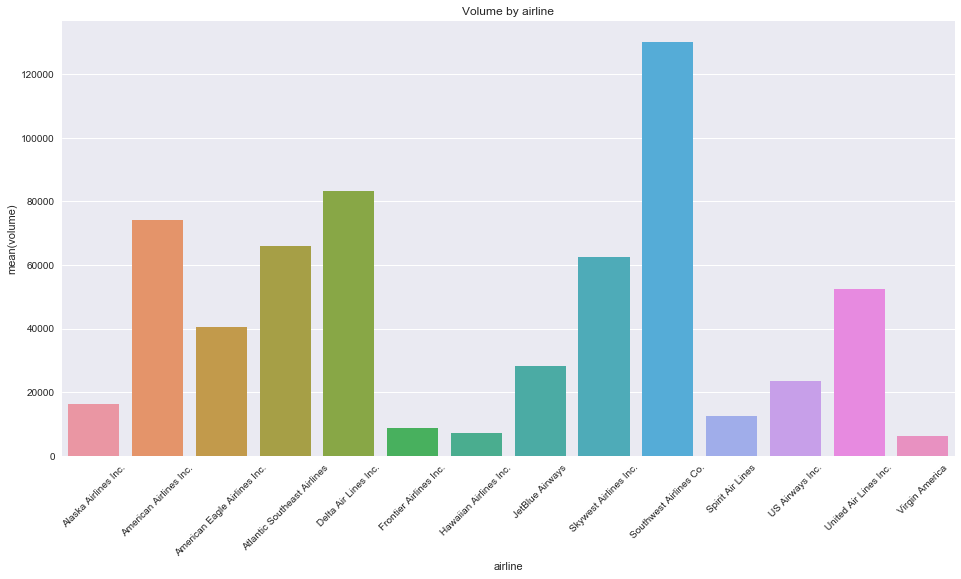

In [9]:
fig = plt.figure(figsize=(16, 8))
ax = sns.barplot(x='airline', y='volume', data=volume_airline_airport.groupby('airline').sum().reset_index())
ax.set_title('Volume by airline')
plt.xticks(rotation=45);

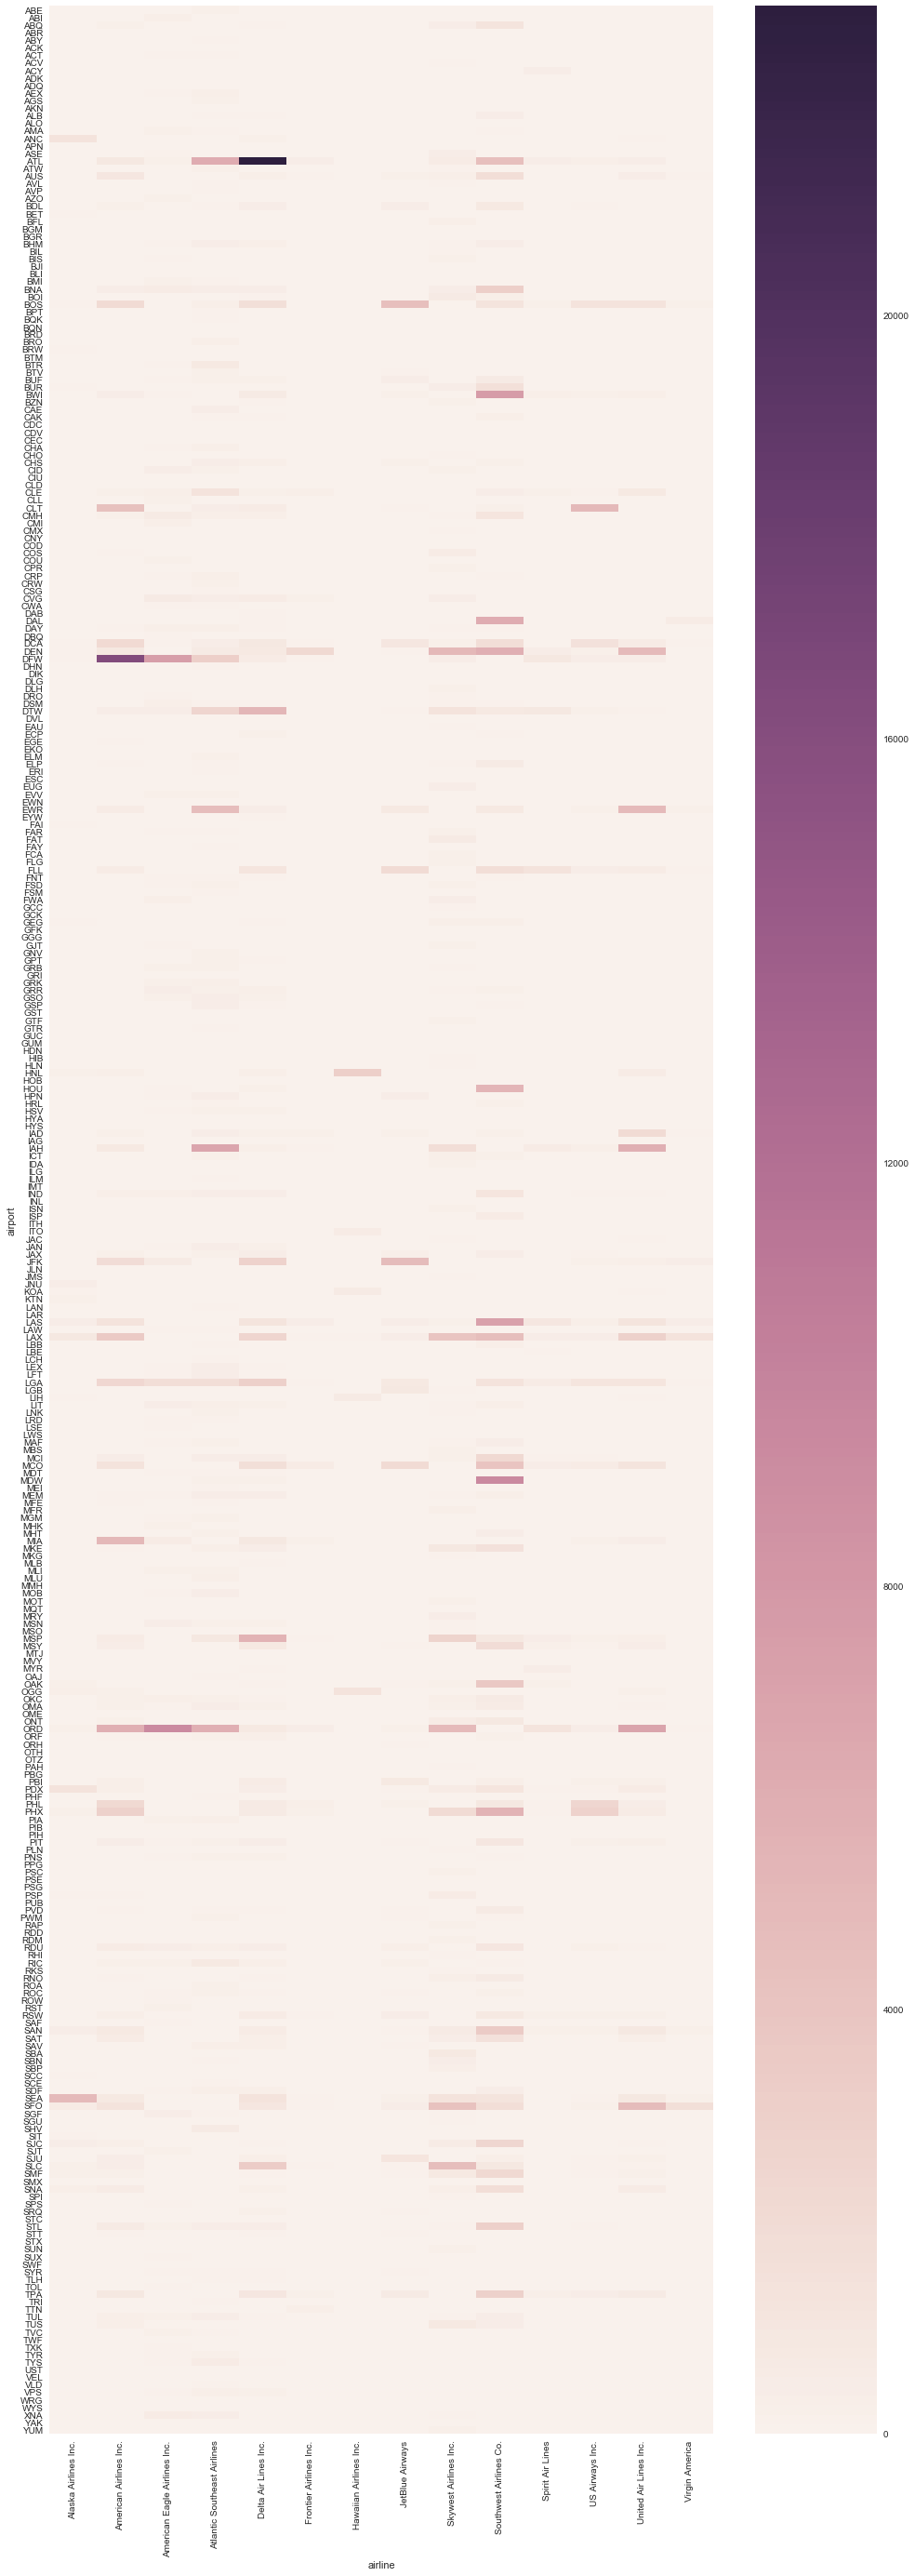

In [10]:
fig = plt.figure(figsize=(16, 48))
#ax = plt.axes()

sns.heatmap(volume_airline_airport.pivot_table(values='volume', index='airport', columns='airline', aggfunc='sum', fill_value=0))

In [11]:
print(volume_airline_airport.groupby('airline').sum()
      .reset_index()
      .sort_values(by='volume', ascending=False)
      .iloc[0, 0])
print(volume_airline_airport[volume_airline_airport.airline=='Southwest Airlines Co.'].groupby('airport').sum()
      .reset_index()
      .sort_values(by='volume', ascending=False)
      .iloc[0, 0])

Southwest Airlines Co.
MDW


## 3. Determine expected times between cancellations for an airline of your choosing.
- Create a table that shows expected time between cancellations, number of cancellations, and number of records per airport.
- Compute and create a table that shows the expected time between cancellations for this airline by month for the top 10 airports. Create a visual for this.

I misinterpreted the expected time between cancellations to be the mean of the times between two cancellations; in the solution the column is the max - min scheduled departure divided by the number of cancellations:

In [66]:
# def cancellations_by_airport(airline):

#     temp = flights[(flights.cancelled==1) & (flights.airline==airline)]\
#             .sort_values(by=['scheduled_departure', 'flight_number'])\
#             .loc[:, ['scheduled_departure', 'flight_number', 'origin_airport']]\
#             .set_index('flight_number')

#     temp['scheduled_departure'] = pd.to_datetime(temp['scheduled_departure'])
#     temp['time_between'] = (temp.scheduled_departure - temp.scheduled_departure.shift(1)).astype('timedelta64[s]') / 3600

#     temp = temp.groupby('origin_airport').aggregate([np.mean, 'count'])
#     temp.columns = temp.columns.droplevel()

#     return pd.DataFrame(flights[flights.airline==airline].groupby('origin_airport').year.count())\
#                 .merge(temp, left_index=True, right_index=True)\
#                 .rename(columns={'year':'number_flights', 'mean':'expected_time_between', 'count':'number_cancellations'})

In [69]:
# cancellations = cancellations_by_airport('DL')#.sort_values(by='number_cancellations', ascending=False)

So let's do it again this way:

In [8]:
cancellations = flights[flights.airline=='DL'].groupby('origin_airport').apply(
    lambda x: pd.Series({
        'number_flights': x.year.count(),
        'number_cancellations': x.cancelled.sum(),
        'expected_time_between': ((pd.to_datetime(x.scheduled_departure.max()) -
                                  pd.to_datetime(x.scheduled_departure.min())).seconds/3600) / (x.cancelled.sum() + 1e-6)
    })
)

In [9]:
cancellations

,expected_time_between,number_cancellations,number_flights
origin_airport,,,
ABE,7.805553e+00,3.0,36.0
ABQ,1.283332e+00,1.0,107.0
AGS,1.875000e+07,0.0,71.0
ALB,3.599999e+00,3.0,112.0
ANC,0.000000e+00,0.0,207.0
ATL,1.539162e-02,915.0,22914.0
ATW,0.000000e+00,1.0,50.0
AUS,1.980000e+00,10.0,340.0
AVL,2.545833e+00,4.0,57.0


In [14]:
# def cancellations_by_airport_month(airline):

#     temp = flights[(flights.cancelled==1) & (flights.airline==airline)]\
#             .sort_values(by=['scheduled_departure', 'flight_number'])\
#             .loc[:, ['scheduled_departure', 'flight_number', 'origin_airport', 'month']]\
#             .set_index('flight_number')

#     temp['scheduled_departure'] = pd.to_datetime(temp['scheduled_departure'])
#     temp['time_between'] = (temp.scheduled_departure - temp.scheduled_departure.shift(1)).astype('timedelta64[s]') / 3600

#     temp = temp.groupby(['origin_airport', 'month']).aggregate([np.mean, 'count'])
#     temp.columns = temp.columns.droplevel()

#     return pd.DataFrame(flights[flights.airline==airline].groupby(['origin_airport', 'month']).year.count())\
#                 .merge(temp, left_index=True, right_index=True)\
#                 .rename(columns={'year':'number_flights', 'mean':'expected_time_between', 'count':'number_cancellations'})

In [17]:
def cancellations_by_airport_month(airline):

    cancellations_by_month = flights[flights.airline==airline].groupby(['origin_airport', 'year', 'month']).apply(
        lambda x: pd.Series({
            'number_flights': x.year.count(),
            'number_cancellations': x.cancelled.sum(),
            'expected_time_between': ((pd.to_datetime(x.scheduled_departure.max()) -
                                      pd.to_datetime(x.scheduled_departure.min())).seconds/3600) / (x.cancelled.sum() + 1e-6)
        })
    )
    
    return cancellations_by_month

In [18]:
top10 = ['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'IAH', 'SFO', 'PHX', 'LAS', 'LGA']

cancellation_month = cancellations_by_airport_month('DL').loc[top10].reset_index()

In [19]:
cancellation_month

,origin_airport,year,month,expected_time_between,number_cancellations,number_flights
0,ATL,2015,1,1.400000e-01,90.0,1894.0
1,ATL,2015,2,2.863512e-02,486.0,2191.0
2,ATL,2015,3,2.256410e-01,65.0,2113.0
3,ATL,2015,4,3.579545e-01,44.0,2084.0
4,ATL,2015,5,3.098214e-01,56.0,2088.0
5,ATL,2015,6,1.724138e-01,87.0,2097.0
6,ATL,2015,7,1.306944e+00,12.0,2187.0
7,ATL,2015,8,1.356060e+00,11.0,2197.0
8,ATL,2015,9,1.551667e+07,0.0,2063.0
9,ATL,2015,11,7.583330e+00,2.0,2041.0


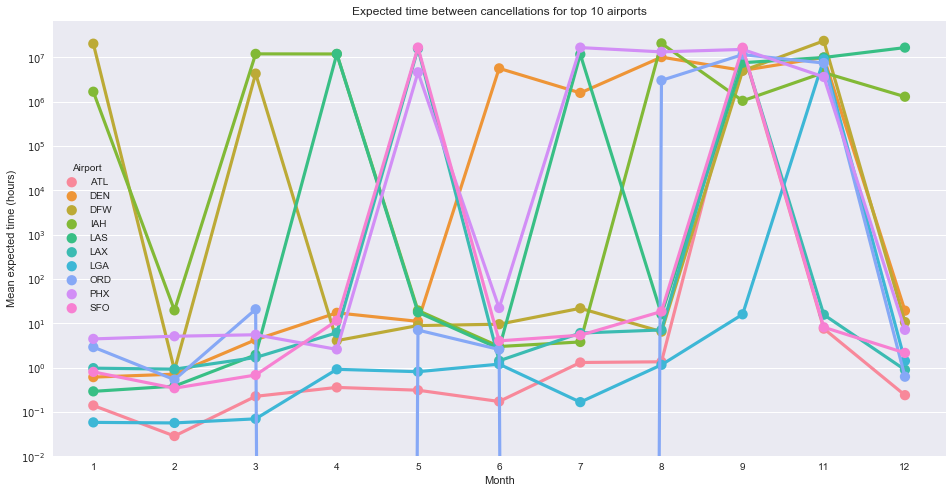

In [28]:
fig = plt.figure(figsize=(16, 8))
ax = plt.axes()
ax = sns.pointplot(x='month', y='expected_time_between', hue='origin_airport', data=cancellation_month)
ax.set_title('Expected time between cancellations for top 10 airports')
ax.set_ylabel('Mean expected time (hours)')
ax.set_xlabel('Month')
ax.set_yscale('log')
ax.legend(title='Airport');

## 4. Model the time between cancellations as a Poisson distribution
- For the Delta Air data for BOS airport in month 5 (May), compute the probability of the expected time between cancellation exceeding 5.

In [33]:
import math

mu = cancellations_by_airport_month('DL').loc['BOS', 2015, 5].expected_time_between
x = 5

print(stats.poisson.sf(k=x, mu=mu))

0.118631500385


## 5. Is there a significant difference between the three most active airlines for overall cancellation rates?

In [38]:
cancellation_counts = flights[flights.airline.isin(['WN', 'DL', 'AA'])].pivot_table(values='year', columns='cancelled', index='airline', aggfunc='count')
cancellation_counts

cancelled,0,1
airline,,
AA,64088,10194
DL,79521,3807
WN,114520,15721


In [39]:
stats.chi2_contingency(cancellation_counts)

(4337.104235239527, 0.0, 2, array([[  66612.02628443,    7669.97371557],
        [  74723.98328302,    8604.01671698],
        [ 116792.99043255,   13448.00956745]]))

The expected frequencies are all above 5 and the p-value is 0, so we can reject the null hypothesis that there is no difference between the cancellation rates for the top 3 airlines.

## 6. Show the relationship between travel routes (origin -> destination) and diversion rates for Delta Air and the top 10 airports from earlier

In [40]:
travel_routes = flights[(flights.airline=='DL')
                        & ((flights.origin_airport.isin(top10))
                            & (flights.destination_airport.isin(top10)))]\
                .loc[:, ['flight_number', 'origin_airport', 'destination_airport', 'diverted']]

# travel_routes['route'] = travel_routes.origin_airport + '-' + travel_routes.destination_airport
# travel_routes.groupby('route').diverted.sum() / travel_routes.groupby('route').diverted.count()

travel_routes.groupby(['origin_airport', 'destination_airport']).diverted.mean().unstack()

destination_airport,ATL,DEN,DFW,IAH,LAS,LAX,LGA,ORD,PHX,SFO
origin_airport,,,,,,,,,,
ATL,NaN,0.000000,0.0,0.0,0.003636,0.0,0.006745,0.0,0.005208,0.0
DEN,0.003891,NaN,NaN,NaN,NaN,NaN,0.011905,NaN,NaN,NaN
DFW,0.002525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IAH,0.004032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAS,0.010309,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
LAX,0.008929,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.0
LGA,0.001529,0.013514,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORD,0.002786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHX,0.005556,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


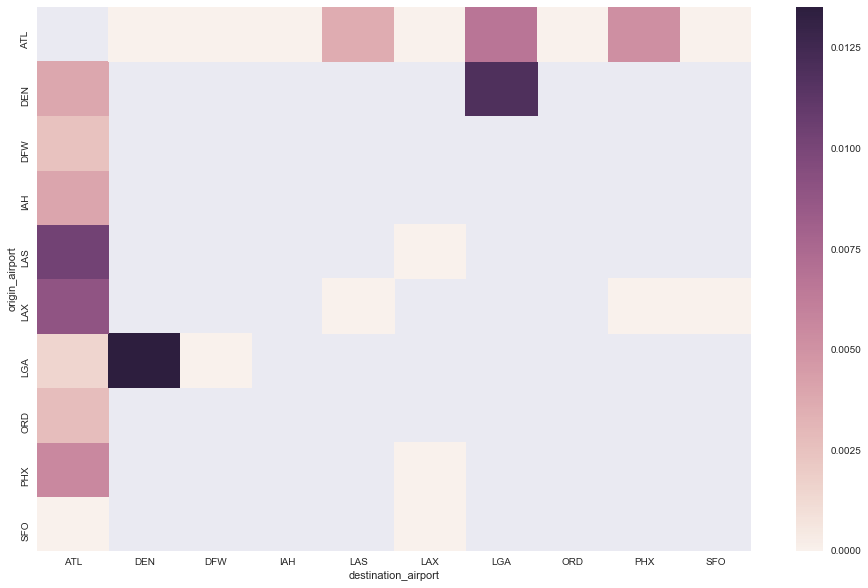

In [43]:
plt.figure(figsize=(16, 10))
sns.heatmap(travel_routes.groupby(['origin_airport', 'destination_airport']).diverted.mean().unstack());

## 7. Create and fill a column for mean ground speed for every flight in miles/hour
- Do any of these seem unusual?
- (distance column is in miles)

In [24]:
flights['ground_speed'] = flights.distance * 1.60934 / flights.air_time * 60

print(flights.sort_values(by='ground_speed').ground_speed.head())
print(flights.sort_values(by='ground_speed', ascending=False).ground_speed.head())

print(flights.iloc[203450])
print(flights.iloc[546104])

546104    5.724117
497055    5.728159
200234    5.728159
571599    5.732207
215116    5.736261
Name: ground_speed, dtype: float64
203450    inf
172729    inf
125225    inf
22891     inf
433556    inf
Name: ground_speed, dtype: float64
year                                  2015
month                                    7
day                                     19
day_of_week                              7
airline                                 OO
flight_number                         2987
tail_number                         N897SK
origin_airport                         ABQ
destination_airport                    PHX
scheduled_departure    2015-07-19 18:35:00
departure_time         2015-07-19 18:46:00
departure_delay                         11
taxi_out                                18
wheels_off             2015-07-19 19:04:00
scheduled_time                          93
elapsed_time                            89
air_time                                 0
distance                          

There are some infinite values due to an airtime of 0 (we have some data cleaning to do I would say) and some very low. It seems that using airtime and distance isn't a good way to measure the ground speed in case of delays for example.

## 8. Create a visual for the mean times of delay reasons for each airline. Create one for delay proportions for each airline.

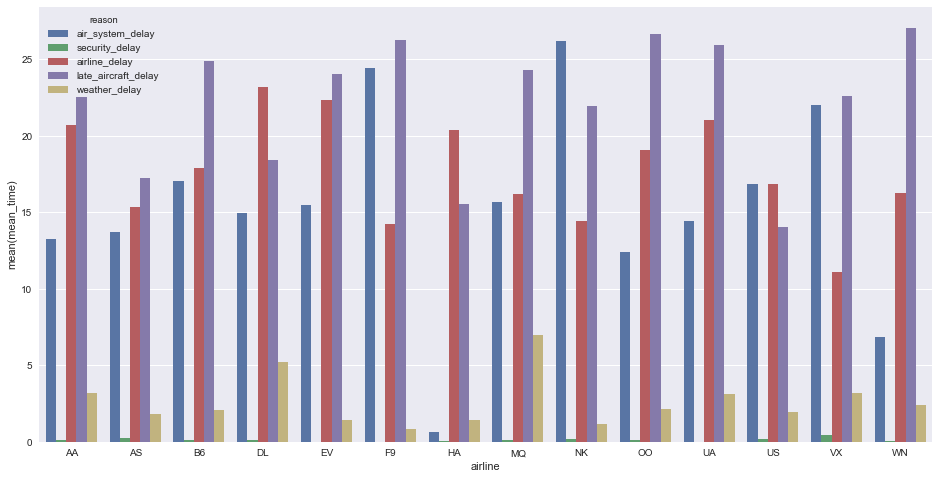

In [45]:
delays = flights.groupby('airline')['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].mean().unstack().reset_index()
delays.columns = ['reason', 'airline', 'mean_time']

fig = plt.figure(figsize=(16, 8))
ax = sns.barplot(x='airline', y='mean_time', data=delays, hue='reason');

I interpreted the delay proportions as the proportion of delays over the total number of flights:

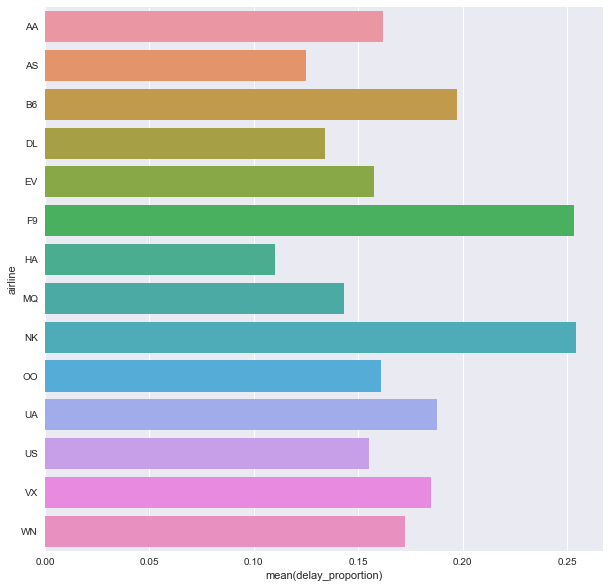

In [26]:
delay_proportion = (flights.groupby('airline').airline_delay.count() / flights.groupby('airline').year.count()).reset_index()
delay_proportion.columns = ['airline', 'delay_proportion']

fig = plt.figure(figsize=(10, 10))
ax = sns.barplot(x='delay_proportion', y='airline', data=delay_proportion);

This is the way it is done in the solutions:

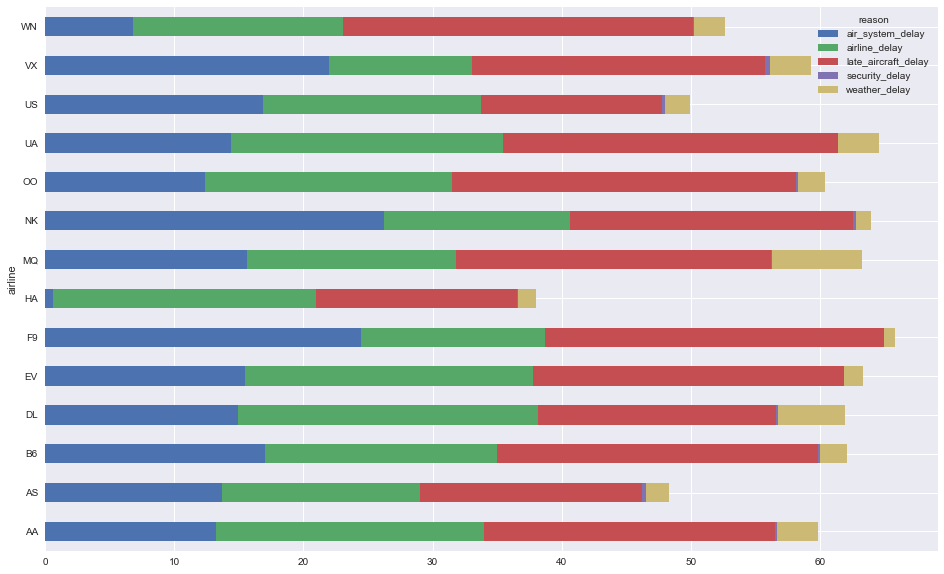

In [56]:
ax = delays.pivot_table(columns='reason', index='airline', values='mean_time').plot.barh(figsize=(16, 10), stacked=True);

## 9. Plot the delay reasons by airline using a parallel coordinates plot for the top 3 airlines
- this can take a while so use a random sample of 10% of the data

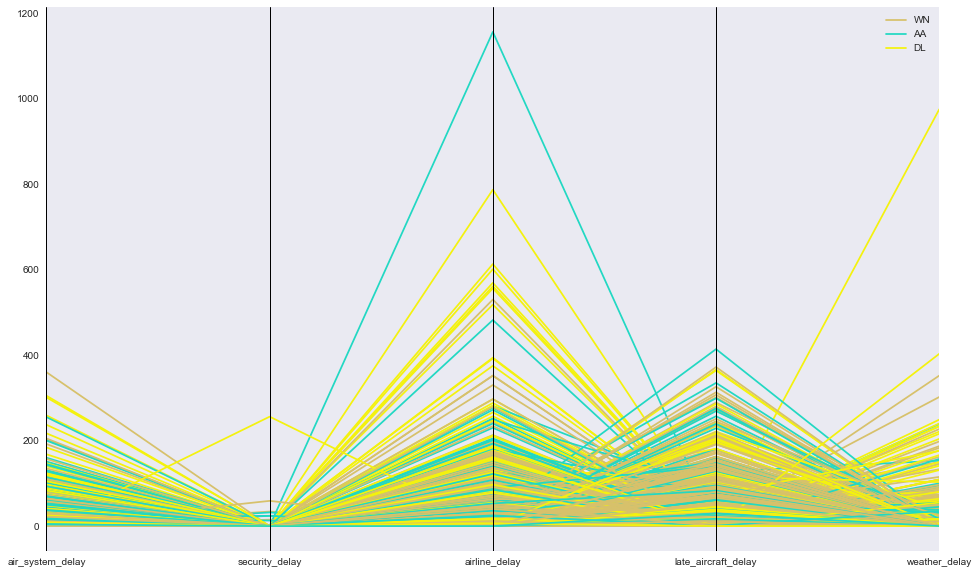

In [27]:
flights_sample = flights[flights.airline.isin(['AA', 'DL', 'WN'])].sample(frac=0.1)

plt.figure(figsize=(16, 10))
pd.tools.plotting.parallel_coordinates(flights_sample[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay', 'airline']], 'airline');

# EDA: Cycle Share

## Exponential distribution property

The exponential distribution has a special property that is referred to as the memoryless property. In terms of time, it states that the probability of an exponential random variable exceeding some value does not depend on how much time has already elapsed. Mathematically it looks like

$$P(X > s + t | X > t) = P(X > s)$$

Where $t$ is the amount of time already elapsed.

## Time series

Pandas offers easy to use tools for working with time series. A couple of these tools include resampling the frequency (downsampling and upsampling), and easily plotting time series.

* Resampling
    - pandas has a `resample()` method that let's us easily downsample and upsample time series
    - downsampling is the process of reducing the frequency of a time series
        + an example of this is changing a time series from hourly to daily or weekly
        + anlalyze groups by day where individuals have different time stamps by time of day
    - upsampling is the opposite, where frequency is increased
        - this requires some form of interpolation
        - upsampling won't be used here
* Plotting
    - plotting time series data with pandas is as easy as all other plotting methods, only we need to set the time series of interest as the index (if it is currently a column).
    - we can use the `set_index()` method to do this.

## 1. Create a plot of min (blue dotted), max (red dotted), and mean (black) temperature over time.
* Give the plot a title, and name the x-axis "Date" and the y-axis "Temp (F)"

In [57]:
cycle = pd.read_csv('data/trip_cleaned.csv')

In [4]:
cycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236065 entries, 0 to 236064
Data columns (total 36 columns):
trip_id                       236065 non-null int64
starttime                     236065 non-null object
stoptime                      236065 non-null object
bikeid                        236065 non-null object
tripduration                  236065 non-null float64
from_station_name             236065 non-null object
to_station_name               236065 non-null object
from_station_id               236065 non-null object
to_station_id                 236065 non-null object
usertype                      236065 non-null object
gender                        146171 non-null object
birthyear                     146167 non-null float64
Max_Temperature_F             236065 non-null int64
Mean_Temperature_F            236065 non-null float64
Min_TemperatureF              236065 non-null int64
Max_Dew_Point_F               236065 non-null int64
MeanDew_Point_F               236065 non-n

In [58]:
temperatures = cycle[['starttime', 'Min_TemperatureF', 'Mean_Temperature_F', 'Max_Temperature_F']].copy()
temperatures['starttime'] = pd.to_datetime(temperatures.starttime)
temperatures.set_index('starttime', inplace=True)

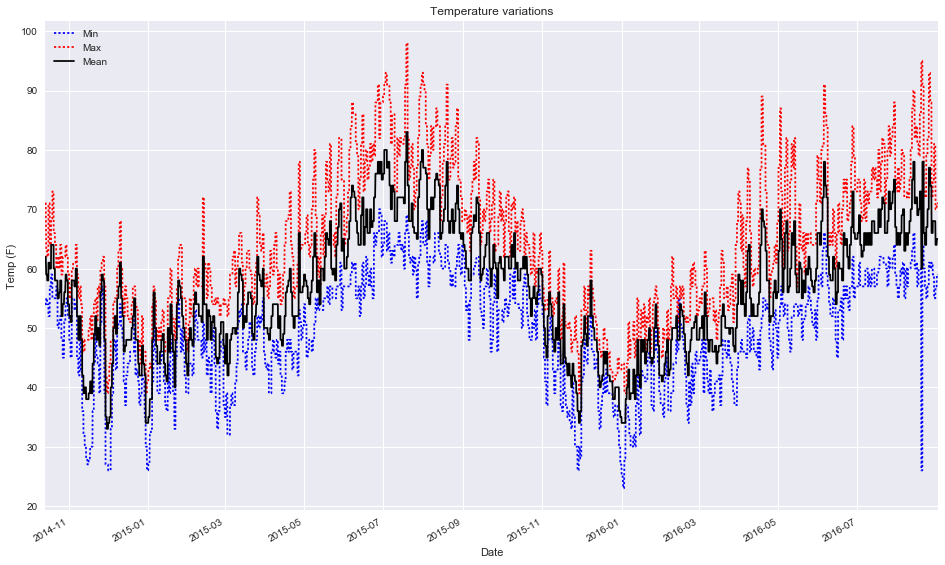

In [59]:
fig = plt.figure(figsize=(16, 10))
ax = temperatures.Min_TemperatureF.plot(kind='line', style=':', color='b', label='Min')
ax = temperatures.Max_Temperature_F.plot(kind='line', style=':', color='r', label='Max')
ax = temperatures.Mean_Temperature_F.plot(kind='line', style='-', color='k', label='Mean')
ax.set_title('Temperature variations')
ax.set_xlabel('Date')
ax.set_ylabel('Temp (F)')
ax.legend();

## 2. Resample the temperature data so that the series includes only one row per day (use the mean), and plot a rolling mean of this resampled data. Use a windows size of 7 days.

In [60]:
temperatures_daily = temperatures.resample('D').mean()

In [61]:
temperatures_roll = temperatures_daily.rolling(7, center=True).mean().dropna()

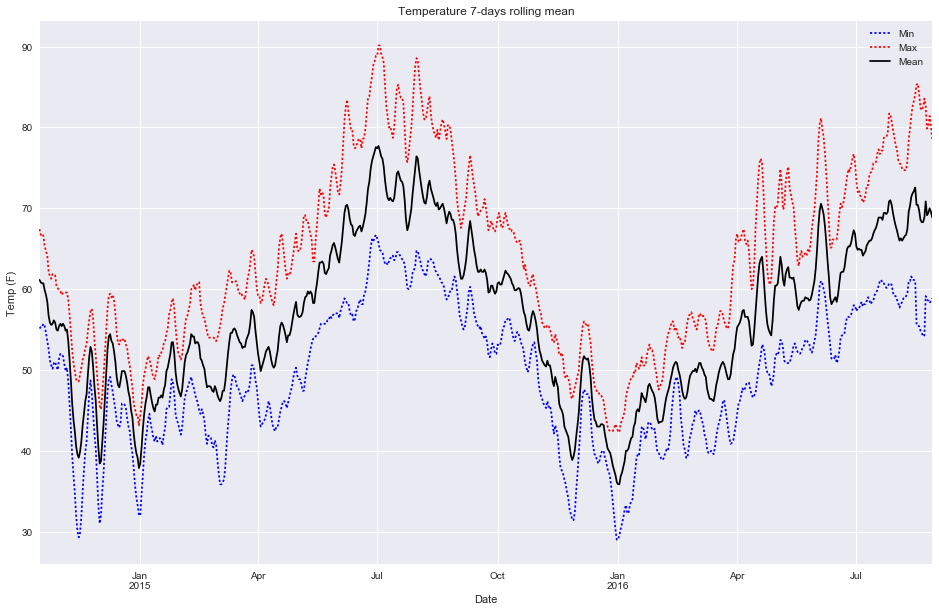

In [62]:
fig = plt.figure(figsize=(16, 10))
ax = temperatures_roll.Min_TemperatureF.plot(kind='line', style=':', color='b', label='Min')
ax = temperatures_roll.Max_Temperature_F.plot(kind='line', style=':', color='r', label='Max')
ax = temperatures_roll.Mean_Temperature_F.plot(kind='line', style='-', color='k', label='Mean')
ax.set_title('Temperature 7-days rolling mean')
ax.set_xlabel('Date')
ax.set_ylabel('Temp (F)')
ax.legend();

## 3. Plot the average number of trips per hour for the month of July (this count will be for all stations)

In [66]:
trips = cycle[['trip_id', 'starttime', 'tripduration', 'from_station_name', 'usertype']].copy()
trips['starttime'] = pd.to_datetime(trips.starttime)
# trips.set_index('starttime', inplace=True)

In [6]:
trips_hourly = trips[trips.starttime.dt.month==7].set_index('starttime')
trips_hourly = trips_hourly.resample('H').trip_id.count().reset_index()
trips_hourly = trips_hourly.groupby(trips_hourly.starttime.dt.hour).trip_id.sum() / 31

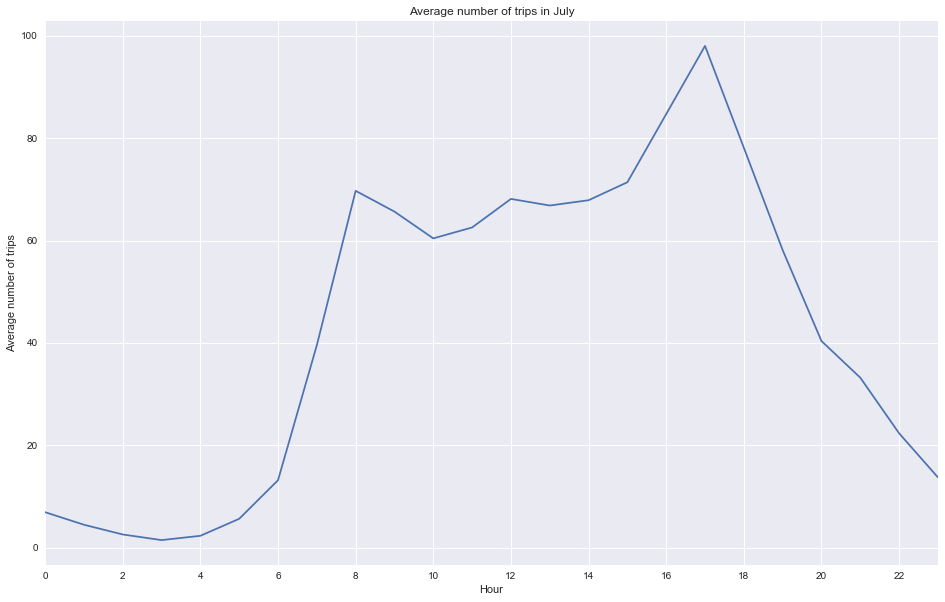

In [7]:
fig = plt.figure(figsize=(16, 10))
ax = trips_hourly.plot(kind='line')
ax.set_title('Average number of trips in July')
ax.set_xlabel('Hour')
ax.set_ylabel('Average number of trips')
ax.xaxis.set_major_locator(plt.MaxNLocator(12));

## 4. Plot the average number of trips per hour, per station for the month of July.

In [8]:
trips_hour_station = trips[trips.starttime.dt.month==7].pivot_table(index='starttime', columns='from_station_name', values='trip_id', aggfunc='count')
trips_hour_station = trips_hour_station.resample('H').count()#.reset_index()
trips_hour_station = trips_hour_station.groupby(trips_hour_station.index.hour).sum() / 31

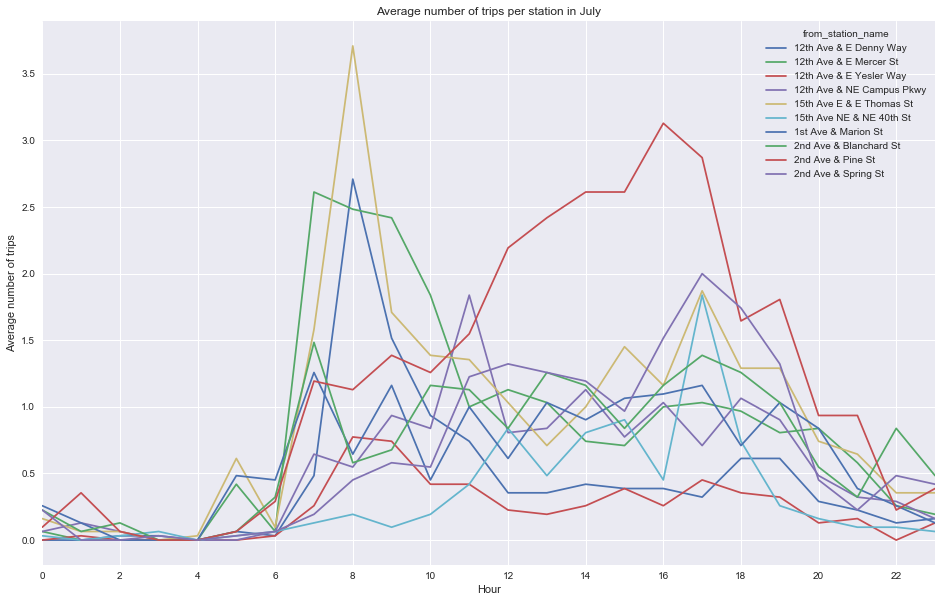

In [9]:
ax = trips_hour_station.iloc[:,0:10].plot(kind='line', figsize=(16, 10))
ax.set_title('Average number of trips per station in July')
ax.set_xlabel('Hour')
ax.set_ylabel('Average number of trips')
ax.set_xticks(range(0, 23, 2));

## 5. Show the distribution of trip durations for the month of May using a histogram with a KDE overlay.

In [67]:
may = trips[trips.starttime.dt.month==5]

C:\Users\alessandro.diantonio\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


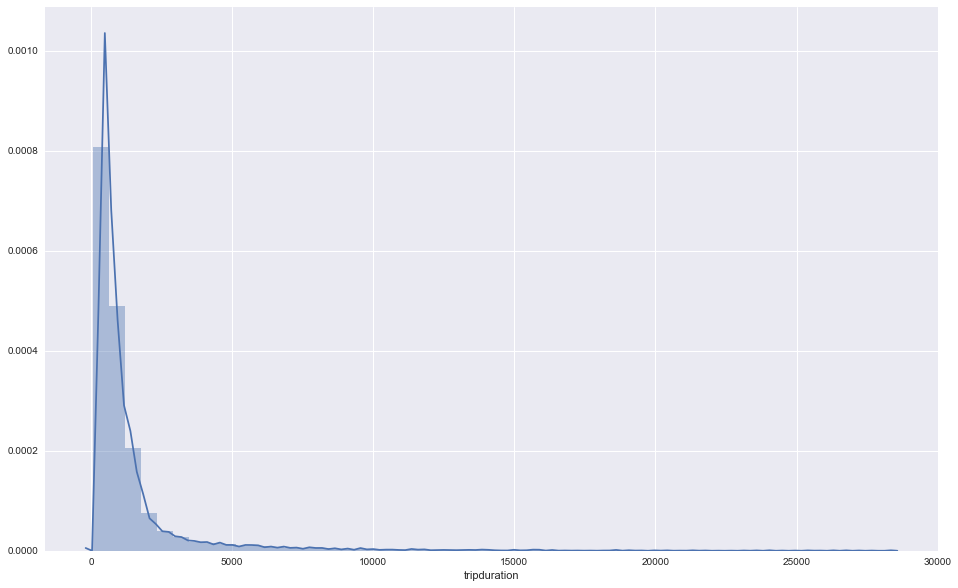

In [68]:
fig = plt.figure(figsize=(16, 10))
ax = sns.distplot(may.tripduration);

## 6. How would you describe this distribution? Determine the following
* What is the expected trip duration in May?
* For the month of May, what is the probability that an individual trip will last for at least 20 minutes?
* If this trip is currently at 14 minutes, what is the probability that it will last for at least another 20 minutes?
* If the trip is currently at 16 minutes, what is the probability that it will last at least a total of 20 minutes?

I would describe this distribution as exponential, the expected value and $P(X>1200)$ are

In [69]:
print(may.tripduration.mean())
print(stats.expon.sf(1200, scale=may.tripduration.mean()))

1305.628519300941
0.398878838765


The probability for the second case is the same as the first because of the memorilessness of the exponentiali distribution.

The probability for the third case is $P(X > 4 \cdot 60)$:

In [70]:
print(stats.expon.sf(240, scale=may.tripduration.mean()))

0.832085970068


## 7. Use pandas to create side-by-side box plots for the trip durations for each station throughout the months of Jun, July, Aug.

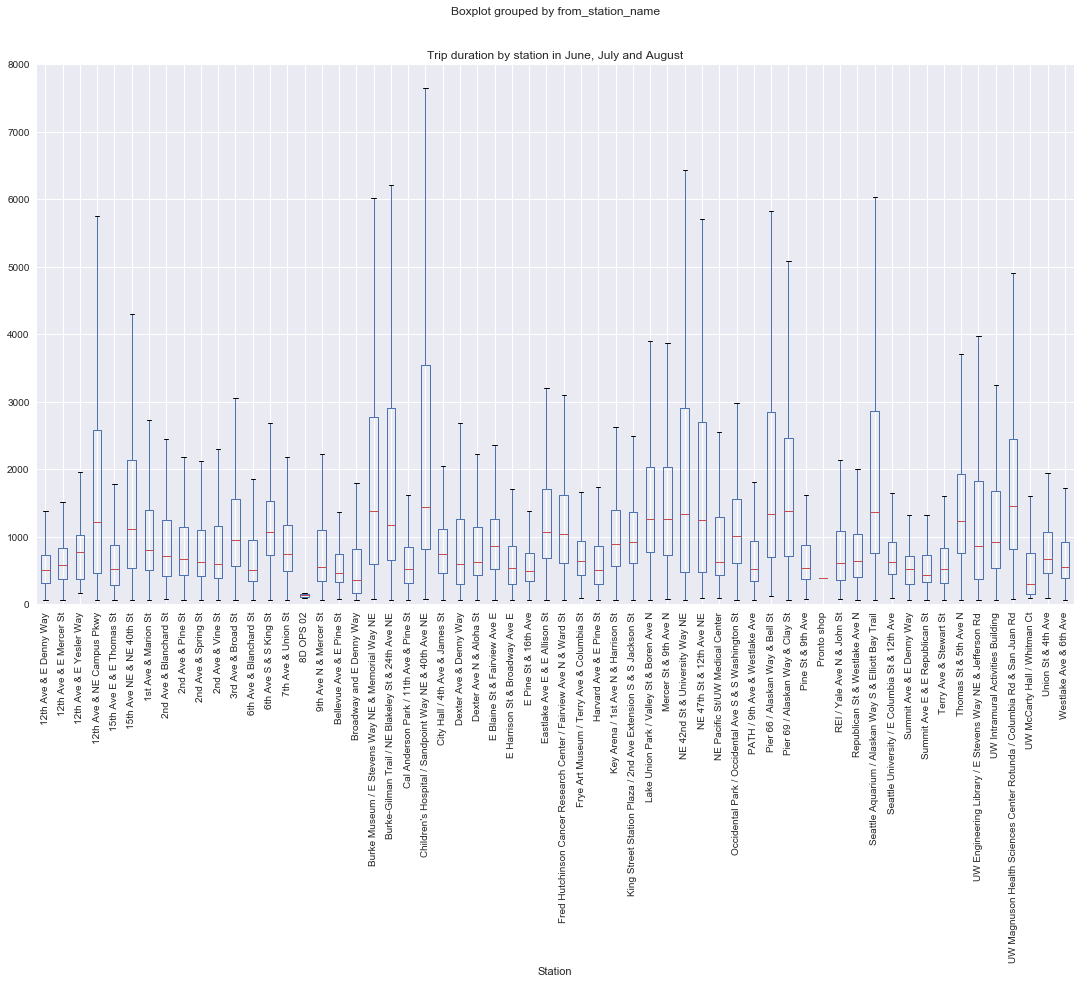

In [82]:
ax = trips[trips.starttime.dt.month.isin([6, 7, 8])].boxplot(column='tripduration', by='from_station_name', figsize=(18,10), rot=90)
ax.set_ylim(0, 8000)
ax.set_title('Trip duration by station in June, July and August')
ax.set_xlabel('Station');

## 8. Use split violin plots to show the differences between usertype for the distributions of tripduration for each year

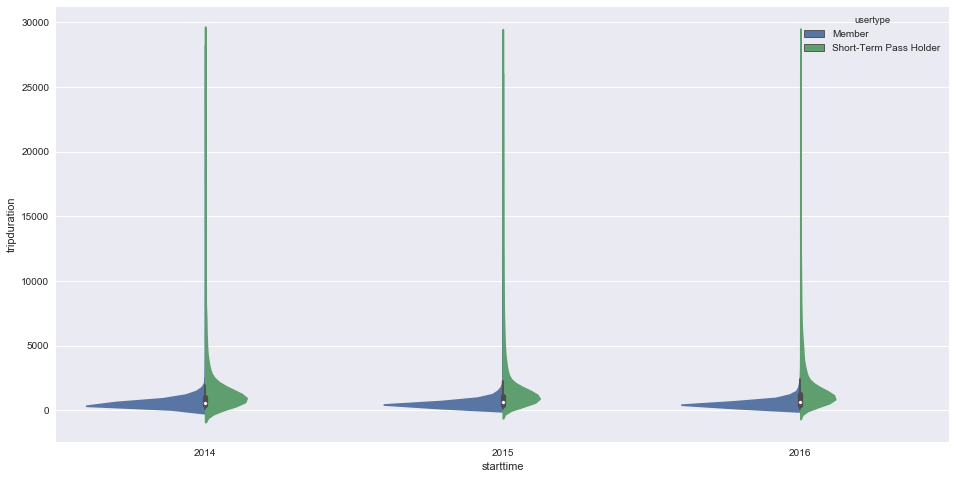

In [87]:
plt.figure(figsize=(16, 8))
ax = sns.violinplot(x=trips.starttime.dt.year, y=trips.tripduration, hue=trips.usertype, split=True)

## 9. Show precipitation and humidity over the course of 2016 in one figure.

In [98]:
water = cycle[['starttime', 'Precipitation_In', 'Mean_Humidity']].copy()
water['starttime'] = pd.to_datetime(water.starttime)
water = water[water.starttime.dt.year==2016]
water.set_index('starttime', inplace=True)

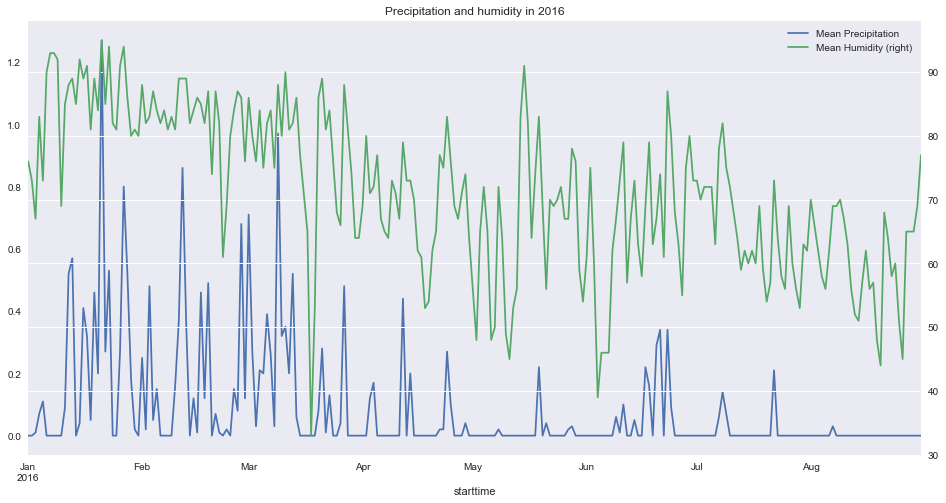

In [103]:
ax = water.resample('D').Precipitation_In.mean().plot(label='Mean Precipitation', figsize=(16, 8), legend=True)
ax = water.resample('D').Mean_Humidity.mean().plot(secondary_y=True, label='Mean Humidity', legend=True)
ax.set_xlabel('Date')
ax.set_title('Precipitation and humidity in 2016');